# Offline Cutmix

In [12]:
import os
import json
import random
from PIL import Image
from pycocotools.coco import COCO
import shutil

In [13]:
import random
random.seed(int(3))

# 기존의 Train folder를 Train과 Val로 나누기

<br>

* 기존 하나의 폴더에 담겨져 있던 이미지를 train 폴더와 val 폴더로 나누어 줍니다.
<br>

* 반드시 아래의 cutmix를 시행하기 이전에 train 폴더와 val 폴더로 나줘주고 각각에 대하여 cutmix를 진행 해주셔야 합니다.
<br>

* val의 json의 file_name을 살펴보면 train/xxxx.jpg 형태인데 이것을 val/xxxx.jpg로 바꿔주는 코드가 포함되어 있습니다.(dataset config에서 경로를 이쁘게하기 위해서)

In [ ]:
# train과 val json 경로
train_json_dir = '../data/split_by_bbox/train2_swj.json'
val_json_dir = '../data/split_by_bbox/val2_swj.json'

# val.json의 file_name에서 train/xxxx.jpg 형식을 모두 val/xxxx.jpg 형식으로
# Load the existing data
with open(val_json_dir, 'r') as f:
    data = json.load(f)

# Modify the paths
for item in data['images']:
    if item['file_name'].startswith('train/'):
        item['file_name'] = item['file_name'].replace('train/', 'val/')

# Write the data back to the file
with open(val_json_dir, 'w') as f:
    json.dump(data, f)

In [ ]:
# Load the json files
with open(train_json_dir) as f:
    train_data = json.load(f)

with open(val_json_dir) as f:
    val_data = json.load(f)

# 나눌 train과 val이 들어갈 경로    
output_train_dir = '../data/split_by_bbox/split/train'
output_val_dir = '../data/split_by_bbox/split/val'

# Make sure the directories exist
os.makedirs(output_train_dir, exist_ok=True)
os.makedirs(output_val_dir, exist_ok=True)

# 나눠야 할 기존의 dataset이 들어가있는 경로
original_train_data = '../data/split_by_bbox/train/'

# Copy the images for the training dataset
for img in train_data['images']:
    filename = os.path.basename(img['file_name'])  # Or img['id'] if it's the id
    source = os.path.join(original_train_data, filename)
    destination = os.path.join(output_train_dir, filename)
    if os.path.exists(source):  # Check if the file exists before copying
        shutil.copyfile(source, destination)
    else:
        print(f"File {source} not found!")

# Do the same for the validation dataset copy section
for img in val_data['images']:
    filename = os.path.basename(img['file_name'])  # Or img['id'] if it's the id
    source = os.path.join(original_train_data, filename)
    destination = os.path.join(output_val_dir, filename)
    if os.path.exists(source):  # Check if the file exists before copying
        shutil.copyfile(source, destination)
    else:
        print(f"File {source} not found!")

# 함수 정의

<br>

* IoU 계산하는 함수 -> IoU 기준으로 많이 겹치는 경우 paste 진행하지 않음
<br>

* 설정한 target_label 중에서 다른 클래스가 존재하는 이미지는 무시, bounding box를 선택하는 기준은 무조건 target_label에서 선택되도록 램덤하게 고름. 이때 오려낸 bounding box가 붙일 이미지의 bounding box와 많이 겹쳐서 기준을 통과하지 못하면 진행하지 않음(확실하지는 않음, 교차검증 x)

In [37]:
# Calculate the Intersection over Union (IoU) between two bounding boxes
def calculate_iou(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    # Calculate coordinates of the intersection rectangle
    x_intersection = max(x1, x2)
    y_intersection = max(y1, y2)
    w_intersection = max(0, min(x1 + w1, x2 + w2) - x_intersection)
    h_intersection = max(0, min(y1 + h1, y2 + h2) - y_intersection)

    # Calculate areas of intersection and union
    intersection_area = w_intersection * h_intersection
    bbox1_area = w1 * h1
    bbox2_area = w2 * h2
    union_area = bbox1_area + bbox2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0

    return iou

def augment_images(target_labels, iou_t, output_json_path, output_dir, GT_JSON, dataset_type, data_dir, original_img_dir):
    # Set the paths and variables
    LABEL_NAME = [
        "General trash", "Paper", "Paper pack", "Metal", "Glass",
        "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"
    ]

    # Set the output directory for augmented images
    train_dir = os.path.join(output_dir, f'{dataset_type}')
    os.makedirs(train_dir, exist_ok=True)
    
    # Copy original images to the new train directory
    
    original_dir = original_img_dir+f'{dataset_type}'
    for filename in os.listdir(original_dir):
        if filename.endswith(".jpg"):  # assuming your images are in jpg format
            shutil.copy(os.path.join(original_dir, filename), train_dir)
    
    # Load ground truth annotations
    with open(GT_JSON, 'r') as outfile:
        original_dataset = json.load(outfile)

    coco_train = COCO(GT_JSON)

    # Set the starting ID for new images
    new_image_id = max([img['id'] for img in coco_train.dataset['images']]) + 1
    new_annotation_id = max([ann['id'] for ann in coco_train.dataset['annotations']]) + 1
    
    # Get the list of source image IDs
    source_image_ids = [img['id'] for img in coco_train.dataset['images']]
    
    num_augmented_images = len(source_image_ids)

    # Initialize the new images and annotations lists
    new_images = []
    new_annotations = []

    # Iterate through the augmented images and add their details to the 'images' field
    for i in range(num_augmented_images):
        # Select a source image in order
        source_image_id = source_image_ids[i]
        source_image_info = coco_train.imgs[source_image_id]
        source_image_path = os.path.join(data_dir, source_image_info['file_name'])
        source_image = Image.open(source_image_path)
        source_image_width, source_image_height = source_image.size

        # Retrieve the bounding boxes and labels for the source image
        source_ann_ids = coco_train.getAnnIds(imgIds=source_image_info['id'])
        source_annotations = coco_train.loadAnns(source_ann_ids)

        target_annotations = [
            ann for ann in source_annotations if LABEL_NAME[ann['category_id']] in target_labels
        ]

        if len(target_annotations) == 0:
            continue

        # Randomly select a target bounding box from the source image
        target_annotation = random.choice(target_annotations)
        target_bbox = target_annotation['bbox']
        target_label = LABEL_NAME[target_annotation['category_id']]

        # Keep selecting a destination image until one is found that only contains the desired classes
        while True:
            destination_image_id = random.choice(source_image_ids)
            destination_image_info = coco_train.imgs[destination_image_id]
            destination_ann_ids = coco_train.getAnnIds(imgIds=destination_image_info['id'])
            destination_annotations = coco_train.loadAnns(destination_ann_ids)

            # Check if all annotations belong to the desired classes
            if all(LABEL_NAME[ann['category_id']] in target_labels for ann in destination_annotations):
                break  # Exit the loop if a suitable image is found

        destination_image_path = os.path.join(data_dir, destination_image_info['file_name'])
        destination_image = Image.open(destination_image_path)
        destination_image_width, destination_image_height = destination_image.size

        # Retrieve the existing annotations for the destination image
        destination_ann_ids = coco_train.getAnnIds(imgIds=destination_image_info['id'])
        destination_annotations = coco_train.loadAnns(destination_ann_ids)

        # Create a new image for augmentation by pasting the target bounding box
        augmented_image = destination_image.copy()

        # Calculate the position and size for the pasted bounding box
        target_x, target_y, target_w, target_h = target_bbox
        target_x1 = int(target_x)
        target_y1 = int(target_y)
        target_x2 = int(target_x + target_w)
        target_y2 = int(target_y + target_h)

        # Find a suitable position to paste the target bounding box
        max_trials = 50
        trial_count = 0

        while trial_count < max_trials:
            # Generate random coordinates for the paste position
            paste_x = random.randint(0, destination_image_width - int(target_w))
            paste_y = random.randint(0, destination_image_height - int(target_h))

            # Check if the pasted bounding box overlaps with existing bounding boxes
            paste_bbox = [paste_x, paste_y, paste_x + int(target_w), paste_y + int(target_h)]
            overlapping_bboxes = [
                ann for ann in destination_annotations if calculate_iou(ann['bbox'], paste_bbox) > iou_t
            ]

            # If there are no overlapping bounding boxes, proceed with the paste operation
            if len(overlapping_bboxes) == 0:
                augmented_image.paste(
                    source_image.crop((target_x1, target_y1, target_x2, target_y2)), (paste_x, paste_y)
                )
                annotation_bbox = [paste_x, paste_y, target_w, target_h]

                # Update the destination annotations with the pasted bounding box
                new_annotation = {
                    'id': new_annotation_id,
                    'image_id': int(new_image_id),
                    'category_id': LABEL_NAME.index(target_label),
                    'bbox': annotation_bbox,
                    'area': target_w * target_h,
                    'iscrowd': 0
                }
                new_annotation_id += 1

                coco_train.dataset['annotations'].append(new_annotation)

                # Update the destination annotations list
                destination_annotations.append(new_annotation)

                break  # Exit the loop once a successful paste is done

            trial_count += 1

        # Save the augmented image
        output_path = os.path.join(train_dir, f'{new_image_id}.jpg')
        augmented_image.save(output_path)

        # Add the augmented image details to the COCO dataset
        new_image_info = {
            'id': int(new_image_id),
            'file_name': f'{dataset_type}/{new_image_id}.jpg',
            'width': destination_image_width,
            'height': destination_image_height
        }
        coco_train.dataset['images'].append(new_image_info)

        # Update the image_id in these annotations to match the new image
        for annotation in destination_annotations:
            # Only copy the annotation if it's not the new one
            if annotation['id'] != new_annotation_id - 1:
                annotation_copy = annotation.copy()
                annotation_copy['id'] = new_annotation_id
                annotation_copy['image_id'] = new_image_id
                new_annotations.append(annotation_copy)

                # Increment the annotation ID after creating a new annotation
                new_annotation_id += 1

        # Append the new_annotation to the new_annotations list
        new_annotations.append(new_annotation)

        # Append the new image info to the new_images list
        new_images.append(new_image_info)

        # Increment the image ID and successful paste counter
        new_image_id += 1

    # Extend the original dataset with the new lists
    original_dataset['annotations'].extend(new_annotations)
    original_dataset['images'].extend(new_images)

    # Save the updated annotations to a new JSON file
    with open(output_json_path, 'w') as outfile:
        json.dump(original_dataset, outfile)

# 사용법
<br>

* 각 train과 val에 대해 cutmix한 결과를 폴더를 분리해서 저장하고 각각의 json file을 만들어 냅니다.
<br>

* train과 val에 대해 각가 한번씩 실행을 시켜줘야합니다(필요한 경우 경로 지정해서)
<br>

* 학습을 진행 할 경우 dataset config를 경로에 맞게 수정을 해주셔야 합니다

In [ ]:
# -- cutmix를 진행할 클래스
target_labels = ["Styrofoam", "Glass", "Metal", "Paper pack", "Clothing", "Battery"]

# train과 val json에서 불러올 데이터가 나눠져있는 경로
original_img_dir = '../data/split_by_bbox/'

# -- IoU threshold
iou_t = 50

# cutmix 할 data 디렉토리
data_dir = '../data/split_by_bbox'

# -- cutmix 후 만들어지는 이미지의 경로
output_dir = '../data/split_by_bbox_cutmix'

# -- cutmix를 진행하는 dataset(필요한 경우 수정)
dataset_type = "train"

# -- cutmix를 진행할 json(필요한 경우 수정)
GT_JSON = '../data/split_by_bbox/'+f'{dataset_type}2_'+'swj.json'

# -- cutmix 후 나오는 json(필요한 경우 수정)
output_json_path = '../data/split_by_bbox_cutmix/swj2_cutmixed_'+f'{dataset_type}'+'.json'


In [ ]:
augment_images(target_labels, iou_t, output_json_path, output_dir, GT_JSON, dataset_type, data_dir, original_img_dir)

# 데이터셋 경로 설정

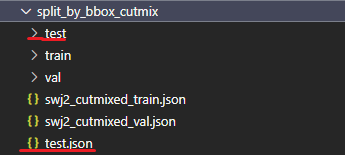

<br>

* 데이터셋 폴더에 test.json과 test 폴더를 넣어주시던가 config에서 따로 경로를 설정해주세요!
<br>

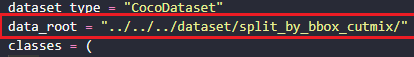

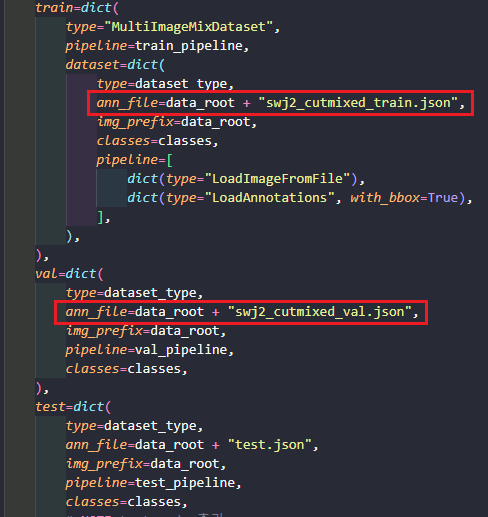
<br>